In [3]:
import numpy as np
import sys
import pandas as pd
sys.path.append('../')
import matplotlib.pyplot as plt
from scipy import signal

from ALT_F_BIND_chromo_vertex_nuclear_competitive_2_density import eval_f_bind_competitive_2, eval_f_bind_competitive_arr_2

In [5]:
def calc_s_bind_comp(ws, mus, f_binds):
    f_bind_10, f_bind_01, f_bind_20, f_bind_02, f_bind_11 = f_binds
    mu_1, mu_2 = mus
    sigma1, sigma2 = sigmas
    w1, w2 = ws

    # boltzmann probability of each binding state [s_HP1, s_PRC1]
    p_00 = 1
    p_10 = np.exp(-f_bind_10 + mu_1*1 - w_1*1) 
    p_01 = np.exp(-f_bind_01 + mu_2*1 - w_2*1)
    p_20 = np.exp(-f_bind_20 + mu_1*2 - w_1*2)
    p_02 = np.exp(-f_bind_02 + mu_2*2 - w_2*2)
    p_11 = np.exp(-f_bind_10 + mu_1*1 - w_1*1  - f_bind_01 + mu_2*1 - w_2*1)
    
    q_bind = p_00 + p_01 + p_10 + p_02 + p_20 + p_11 #1. + np.exp(-eps * sigma + mu - w)
    s_bind1 = (1*p_10 + 2*p_20 + 1*p_11) / q_bind #(f_bind_20 + mu_1 - w_1) + 1*(f_bind_11 + mu_1 - w_1 + mu_2 - w_2) / q_bind
    s_bind2 = (1*p_01 + 2*p_02 + 1*p_11) / q_bind #np.exp(1*(f_bind_01 + mu_2 - w_2) + 2*(f_bind_02 + mu_2 - w_2) + 1(*f_bind_11 + mu_1 - w_1 + mu_2 - w_2) / q_bind

    s_binds = [s_bind1, s_bind2]
    return s_binds

In [7]:
# x: genomic distance
#a = 2.6065
# a = 2.6075, mu = -4.8, v_int = -2 : get bridging
def calc_p_loop(x, a = 2.6075):
    
    p_loop = a / np.abs(x) ** (1.5)
    
    return p_loop

In [9]:
%%time
# 2 marks competitive, no for loop

n_nuc = 100000
n_iter = 70

w_1 = np.zeros(n_nuc)
w_2 = np.zeros(n_nuc)
ws = [w_1, w_2]

# mus = [-4.8,-4.8]
mus = [-4.8,-10]
# eps = -2
# j = -2

sigma_1 = np.random.randint(1, size = n_nuc)
sigma_1[20:40] = 2
sigma_1[60:80] = 2

sigma_2 = np.random.randint(1, size = n_nuc)
sigma_2[40:60] = 2
sigma_2[80:100] = 2

sigmas = [sigma_1, sigma_2]

# e_m = [1.52, 1.52]
# v_int = np.array([[-4,0],[0,-4]])

e_m = [2, 2]
v_int = np.array([[-2,0],[0,-2]])

f_bind_10 = eval_f_bind_competitive_arr_2([1,0], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_01 = eval_f_bind_competitive_arr_2([0,1], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_20 = eval_f_bind_competitive_arr_2([2,0], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_02 = eval_f_bind_competitive_arr_2([0,2], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_11 = eval_f_bind_competitive_arr_2([1,1], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_binds_comp = [f_bind_10, f_bind_01, f_bind_20, f_bind_02, f_bind_11]

for i in range(n_iter):
    s_arr = calc_s_bind_comp(ws, mus, f_binds_comp) # binding state of HP1 and PRC1
    # s = calc_s_bind(w, sigma, eps, mu)

    i = 0
    p_loop_ini = np.concatenate((calc_p_loop(np.arange(0,i)-i),np.array([0]),calc_p_loop(np.arange(i + 1, n_nuc)-i)))
    p_loop_reflect = np.concatenate((p_loop_ini[1:][::-1], p_loop_ini))
    
    p_s_sum1 = signal.convolve(s_arr[0], p_loop_reflect, mode = "valid") # equivalent to [np.sum(p_loop * s_arr[0])] for i in range (n_nuc)
    p_s_sum2 = signal.convolve(s_arr[1], p_loop_reflect, mode = "valid") # equivalent to [np.sum(p_loop * s_arr[1])] for i in range (n_nuc)
    
    w_1_fast = v_int[0,0] * p_s_sum1 +  v_int[0,1] * p_s_sum2
    w_2_fast = v_int[1,1] * p_s_sum2 +  v_int[0,1] * p_s_sum1

    w_s = [w_1_fast, w_2_fast]

    # for i in range(n_nuc):
    #     p_loop = np.concatenate((calc_p_loop(np.arange(0,i)-i),np.array([0]),calc_p_loop(np.arange(i + 1, n_nuc)-i))) 
    #     # gives array of looping probs centered at ith nucleosome (at which probability = 0) 
    #     w_1[i] = v_int[0,0] * np.sum(p_loop * s_arr[0]) +  v_int[0,1] * np.sum(p_loop * s_arr[1])
    #     w_2[i] = v_int[1,1] * np.sum(p_loop * s_arr[1]) +  v_int[0,1] * np.sum(p_loop * s_arr[0])
    #     w_s = [w_1, w_2]
    #     # QUESTION: why is this the expression for w? saddle point equation?

CPU times: total: 1.5 s
Wall time: 3.23 s


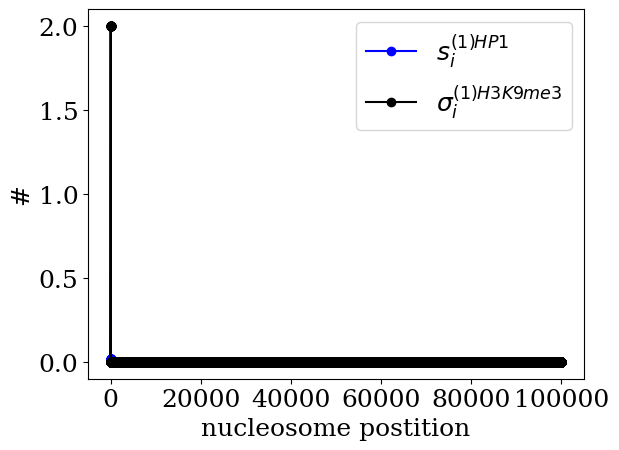

In [12]:
# QUESTION: why is final s_bind ("s") this way? middle unmarked section has binding
plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(s_arr[0], 'bo-', label = "$s^{(1)HP1}_i$")
# plt.plot(s_arr[1], 'ro-', label = "$s^{(2)PRC1}_i$")

plt.plot(sigma_1, 'ko-', label = "$\sigma^{(1)H3K9me3}_i$")
# plt.plot(sigma_2, 'go-', label = "$\sigma^{(2)H3K27me3}_i$")
plt.xlabel("nucleosome postition")
plt.ylabel("#")
plt.legend()

plt.show()

In [ ]:
# TODO
# compare to andy result DONE
# OPTIMIZE- change form of looping probabililty to only consider 200 nearest? DONE
# look at different v_int systems - understand relationship between mu, v_int, and a (looping prob magnitude)
# Co-occupancy map. compare to chromo? understand phase behavior?
# generate 2d density maps vs mu? to compare with theory

# Andys work

In [89]:
# single nucleosome binding partition function
def calc_q_bind(w, sigma, eps = 0, mu = 0):
    q_bind = 1. + np.exp(-eps * sigma + mu - w)
    
    return q_bind

In [90]:
# average s_bind
# sigma: mark state!
# QUESTION what is epsilon (binding param?)
def calc_s_bind(w, sigma, eps = 0, mu = 0):
    q_bind = 1. + np.exp(-eps * sigma + mu - w)
    s_bind = np.exp(-eps * sigma + mu - w) / q_bind
    
    return s_bind



In [91]:
# x: genomic distance
def calc_p_loop(x, a = 1):
    
    p_loop = a / np.abs(x) ** (1.5)
    
    return p_loop

In [5]:
np.arange(5, 10) - 4

array([1, 2, 3, 4, 5])

In [105]:
n_nuc = 100
n_iter = 70

w = np.zeros(n_nuc)

mu = -4.8
eps = -2
sigma = np.random.randint(1, size = n_nuc)
sigma[20:40] = 1
sigma[60:80] = 1
j = -2

for i in range(n_iter):
    s = calc_s_bind(w, sigma, eps, mu)
    for i in range(n_nuc):
        p_loop = np.concatenate((calc_p_loop(np.arange(0,i)-i),np.array([0]),calc_p_loop(np.arange(i + 1, n_nuc)-i))) 
        # gives array of looping probs centered at ith nucleosome (at which probability = 0) 
        w[i] = j * np.sum(p_loop * s)
        # QUESTION: why is this the expression for w? saddle point equation?

In [106]:
sigma

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

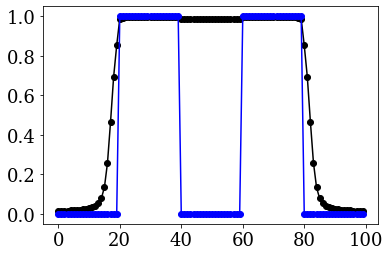

In [107]:
# QUESTION: why is final s_bind ("s") this way? middle unmarked section has binding
plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(s, 'ko-')
plt.plot(sigma, 'bo-')

plt.show()

In [86]:
n_nuc = 10000
n_iter = 20

w = np.zeros(n_nuc)

mu = -4.5
eps = -2
sigma = np.random.randint(2, size = n_nuc)
sigma[40:60] = 1
j = -2

for i in range(n_iter):
    s = calc_s_bind(w, sigma, eps, mu)
    for i in range(n_nuc):
        p_loop = np.concatenate((calc_p_loop(np.arange(0,i)-i),np.array([0]),calc_p_loop(np.arange(i + 1, n_nuc)-i)))
        w[i] = j * np.sum(p_loop * s)


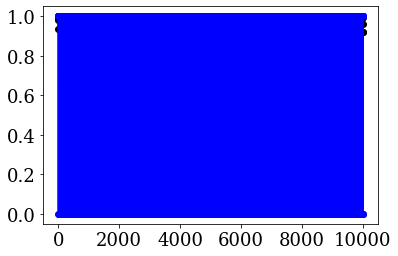

In [87]:
plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(s, 'ko-')
plt.plot(sigma, 'bo-')

plt.show()

# Old efficiency testing code

In [393]:


# # TESTING for efficiency


# # 2 marks competitive

# n_nuc = 4
# n_iter = 1

# w_1 = np.zeros(n_nuc)
# w_2 = np.zeros(n_nuc)
# ws = [w_1, w_2]

# # mus = [-4.8,-4.8]
# mus = [-4.8,-10]
# # eps = -2
# # j = -2

# sigma_1 = [0,2,1,2]#np.random.randint(1, size = n_nuc)
# # sigma_1[2:4] = 2
# # sigma_1[60:80] = 2

# sigma_2 = np.random.randint(1, size = n_nuc)
# # sigma_2[40:60] = 2
# # sigma_2[80:100] = 2

# sigmas = [sigma_1, sigma_2]

# # e_m = [1.52, 1.52]
# # v_int = np.array([[-4,0],[0,-4]])

# e_m = [2, 2]
# v_int = np.array([[-2,0],[0,-2]])

# f_bind_10 = eval_f_bind_competitive_arr_2([1,0], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
# f_bind_01 = eval_f_bind_competitive_arr_2([0,1], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
# f_bind_20 = eval_f_bind_competitive_arr_2([2,0], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
# f_bind_02 = eval_f_bind_competitive_arr_2([0,2], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
# f_bind_11 = eval_f_bind_competitive_arr_2([1,1], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
# f_binds_comp = [f_bind_10, f_bind_01, f_bind_20, f_bind_02, f_bind_11]

# p_loop_initial = None

# for i in range(n_iter):
#     s_arr = calc_s_bind_comp(ws, mus, f_binds_comp) # binding state of HP1 and PRC1
#     # s = calc_s_bind(w, sigma, eps, mu)
    
#     n_nuc = 4
#     for i in range(n_nuc):
#         p_loop = np.concatenate((calc_p_loop(np.arange(0,i)-i),np.array([0]),calc_p_loop(np.arange(i + 1, n_nuc)-i)))
#         if i == 0:
#             p_loop_initial = p_loop
#         print("-------------------------")
#         print("p_loop:", p_loop)
#         print("s_bind:", s_arr[0])
#         print("sum(s_bind*p_loop):", np.sum(s_arr[0]*p_loop))
#         print("conv:", signal.convolve(s_arr[0], p_loop, mode = "valid"))
#         w_1[i] = v_int[0,0] * np.sum(p_loop * s_arr[0]) +  v_int[0,1] * np.sum(p_loop * s_arr[1])
#         w_2[i] = v_int[1,1] * np.sum(p_loop * s_arr[1]) +  v_int[0,1] * np.sum(p_loop * s_arr[0])
#         w_s = [w_1, w_2]

#         p_loop_reflect = np.concatenate((p_loop_initial[1:][::-1], p_loop_initial))
#         print("conv reflect:", signal.convolve(s_arr[0], p_loop_reflect, mode = "valid"))        
#         # print("sum(s_bind*p_loop):", np.sum(s_arr[0]*p_loop))
# print("w1:", w_1)
# print("w2:", w_2)

# i = 0
# p_loop_ini = np.concatenate((calc_p_loop(np.arange(0,i)-i),np.array([0]),calc_p_loop(np.arange(i + 1, n_nuc)-i)))
# p_loop_reflect = np.concatenate((p_loop_ini[1:][::-1], p_loop_ini))

# p_s_sum1 = signal.convolve(s_arr[0], p_loop_reflect, mode = "valid") # equivalent to [np.sum(p_loop * s_arr[0])] for i in range (n_nuc)
# p_s_sum2 = signal.convolve(s_arr[1], p_loop_reflect, mode = "valid") # equivalent to [np.sum(p_loop * s_arr[1])] for i in range (n_nuc)
# w_1_fast = v_int[0,0] * p_s_sum1 +  v_int[0,1] * p_s_sum2
# w_2_fast = v_int[1,1] * p_s_sum2 +  v_int[0,1] * p_s_sum1

# print("new w1:", w_1_fast)
# print("new w2:", w_2_fast)


-------------------------
p_loop: [0.         2.6075     0.92189047 0.50181361]
s_bind: [0.00224087 0.0171692  0.0093906  0.0171692 ]
sum(s_bind*p_loop): 0.06204152046292194
conv: [0.04143861]
conv reflect: [0.06204152 0.04615718 0.09160319 0.04143861]
-------------------------
p_loop: [2.6075     0.         2.6075     0.92189047]
s_bind: [0.00224087 0.0171692  0.0093906  0.0171692 ]
sum(s_bind*p_loop): 0.04615717824651325
conv: [0.09160319]
conv reflect: [0.06204152 0.04615718 0.09160319 0.04143861]
-------------------------
p_loop: [0.92189047 2.6075     0.         2.6075    ]
s_bind: [0.00224087 0.0171692  0.0093906  0.0171692 ]
sum(s_bind*p_loop): 0.09160319458339453
conv: [0.04615718]
conv reflect: [0.06204152 0.04615718 0.09160319 0.04143861]
-------------------------
p_loop: [0.50181361 0.92189047 2.6075     0.        ]
s_bind: [0.00224087 0.0171692  0.0093906  0.0171692 ]
sum(s_bind*p_loop): 0.041438608668152466
conv: [0.06204152]
conv reflect: [0.06204152 0.04615718 0.09160319